In [1]:
import os
import cv2
import math
import numpy as np
from collections import OrderedDict
import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    total_images += count
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images: {total_images}")

surprise has 249 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
anger has 135 number of images

total images: 750


`sadness` and `fear` has very low number of images as compared to other classes

In [4]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [5]:
img_arr = np.empty(shape=(total_images, 48, 48, 1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

idx = 0
label = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in  TOP_EMOTIONS:
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[idx] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[idx] = label
            idx += 1
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)

img_arr.shape, img_label.shape, label_to_text

((750, 48, 48, 1),
 (750, 5),
 {0: 'surprise', 1: 'fear', 2: 'sadness', 3: 'happy', 4: 'anger'})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((525, 48, 48, 1), (225, 48, 48, 1))

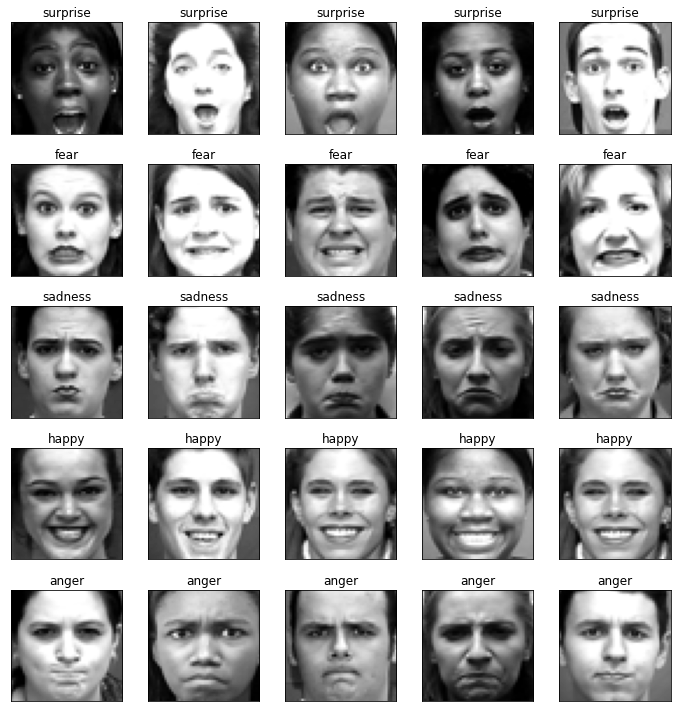

In [7]:
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(y_train[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [8]:
# data normalization
X_train = X_train / 255.
X_test = X_test / 255.

In [9]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.45, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.5, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

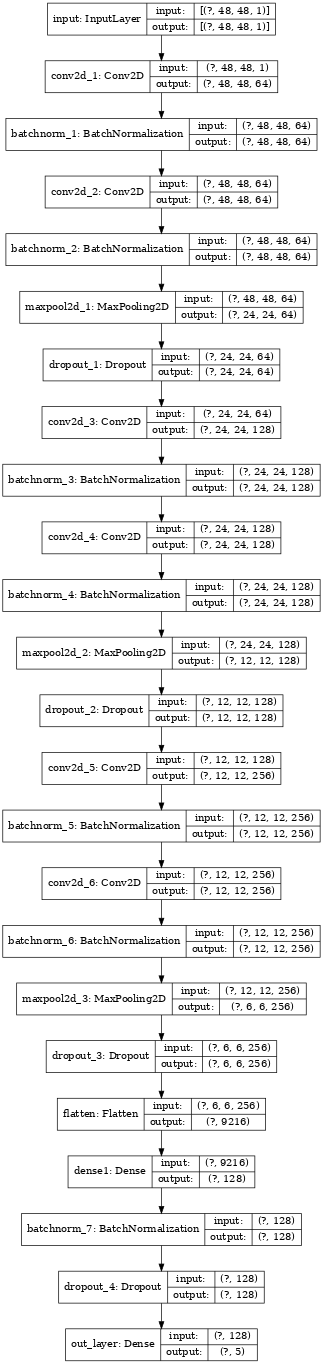

In [10]:
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

batch_size = 10
epochs = 60

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [13]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train for 52.5 steps, validate on 225 samples
Epoch 1/60
53/52 [==============================] - 6s 106ms/step - loss: 2.0841 - accuracy: 0.3524 - val_loss: 17.2468 - val_accuracy: 0.2756
Epoch 2/60
53/52 [==============================] - 1s 14ms/step - loss: 1.4878 - accuracy: 0.5219 - val_loss: 1.7996 - val_accuracy: 0.5822
Epoch 3/60
53/52 [==============================] - 1s 14ms/step - loss: 1.2692 - accuracy: 0.5524 - val_loss: 1.6029 - val_accuracy: 0.5556
Epoch 4/60
53/52 [==============================] - 1s 14ms/step - loss: 1.1202 - accuracy: 0.6152 - val_loss: 1.2610 - val_accuracy: 0.5689
Epoch 5/60
53/52 [==============================] - 1s 14ms/step - loss: 0.9296 - accuracy: 0.6610 - val_loss: 0.4594 - val_accuracy: 0.7911
Epoch 6/60
53/52 [==============================] - 1s 14ms/step - loss: 0.9567 - accuracy: 0.6495 - val_loss: 0.3783 - val_accuracy: 0.8044
Epoch 7/60
53/52 [==============================] - 1s 13ms/step - loss: 0.8437 - accuracy: 0.7029 - val_l

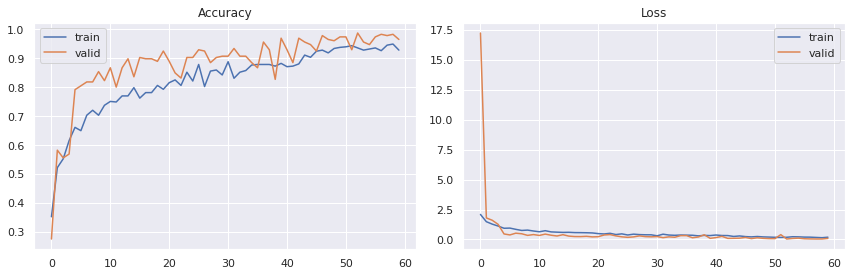

In [14]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [15]:
label_to_text

{0: 'surprise', 1: 'fear', 2: 'sadness', 3: 'happy', 4: 'anger'}

In [16]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'surprise': 0, 'fear': 1, 'sadness': 2, 'happy': 3, 'anger': 4}

test accuracy: 96.4444 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      0.95      0.98        22
           2       0.76      1.00      0.86        25
           3       1.00      1.00      1.00        62
           4       1.00      0.83      0.91        41

    accuracy                           0.96       225
   macro avg       0.95      0.96      0.95       225
weighted avg       0.97      0.96      0.97       225



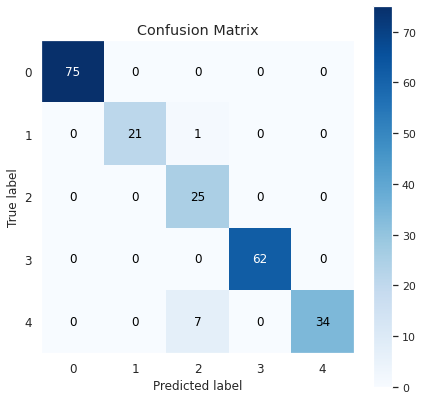

In [17]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [18]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9ac5c0ec18>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9a81c4ecf8>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9a803e4080>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9a8039da90>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9a803d1048>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f9a80397048>)]

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Saved model to disk


In [20]:
# Saving Model weights and json
model_json_file = './model.json'
model_weights_file = './model.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [21]:
# default harcascade 
face_cascade = cv2.CascadeClassifier('../input/haarcascade-frontalface-defaultxml/haarcascade_frontalface_default.xml')

In [22]:
%run -i './scripts/enable_widgets.py'